# Climate Change Tweet Classification using an SVM

In [56]:
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

from discourseparse import DiscourseParsing
from emonal import Emo

In [2]:
with open("../data/tweets.txt","r",encoding="utf-8") as f:
    tweets = f.readlines()
with open("../data/labels.csv","r",encoding="utf-8") as f:
    labels = f.readlines()

In [3]:
y_data = pd.Series([x.strip() for x in labels])

In [4]:
tkznr = TweetTokenizer(reduce_len=True)
def twokenize(text:str):
    return tkznr.tokenize(text)
    

vectorizer_unigram = TfidfVectorizer(tokenizer=twokenize,analyzer='word')
vectorizer_unibigram = TfidfVectorizer(tokenizer=twokenize,analyzer='word',ngram_range=(1,2))
vectorizer_char34gram = TfidfVectorizer(analyzer='char',ngram_range=(3,4))
vectorizer_char45gram = TfidfVectorizer(analyzer='char',ngram_range=(4,5))

## Word-level Unigrams

In [5]:
x_data = vectorizer_unigram.fit_transform(tweets)
x_data.shape

(1999, 4921)

In [6]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.2,random_state=42)

### Parameter-Tuning

In [7]:
unigram_clf = svm.LinearSVC()
unigram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
unigram_grid = model_selection.GridSearchCV(unigram_clf,param_grid=unigram_parameters,scoring='f1_weighted',refit=True,cv=5)
unigram_grid.fit(x_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [8]:
unigram_grid_df = pd.DataFrame(unigram_grid.cv_results_)
unigram_grid.best_params_

{'C': 1}

### Evaluation

In [9]:
y_unigram = unigram_grid.predict(x_test)

In [10]:
sns_conf = metrics.confusion_matrix(y_test,y_unigram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

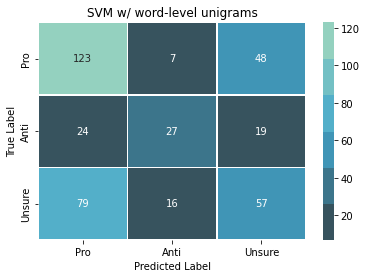

In [11]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ word-level unigrams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [12]:
accuracy = metrics.accuracy_score(y_test,y_unigram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_unigram,pos_label=1,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.5175
Precision: 0.5113676848415644
Recall: 0.5175
F1 Score: 0.5066718682737839



## Word-Level Uni- and Bigrams

In [13]:
x_data = vectorizer_unibigram.fit_transform(tweets)
x_data.shape

(1999, 22407)

In [14]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.2,random_state=42)

### Parameter-Tuning

In [15]:
unibigram_clf = svm.LinearSVC()
unibigram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
unibigram_grid = model_selection.GridSearchCV(unibigram_clf,param_grid=unibigram_parameters,scoring='f1_weighted',refit=True,cv=5)
unibigram_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [16]:
unibigram_grid_df = pd.DataFrame(unibigram_grid.cv_results_)
unibigram_grid.best_params_

{'C': 1000}

### Evaluation

In [17]:
y_unibigram = unibigram_grid.predict(x_test)

In [18]:
sns_conf = metrics.confusion_matrix(y_test,y_unibigram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

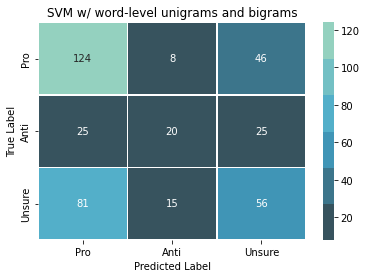

In [19]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ word-level unigrams and bigrams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [20]:
accuracy = metrics.accuracy_score(y_test,y_unigram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_unibigram,pos_label=1,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.5175
Precision: 0.48886744743358035
Recall: 0.5
F1 Score: 0.4849819016006822



## Character-Level Tri- and 4-grams

In [21]:
x_data = vectorizer_char34gram.fit_transform(tweets)
x_data.shape

(1999, 27204)

In [22]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.2,random_state=42)

### Parameter-Tuning

In [23]:
char34gram_clf = svm.LinearSVC()
char34gram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
char34gram_grid = model_selection.GridSearchCV(char34gram_clf,param_grid=char34gram_parameters,scoring='f1_weighted',refit=True,cv=5)
char34gram_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [24]:
char34gram_grid_df = pd.DataFrame(char34gram_grid.cv_results_)
char34gram_grid.best_params_

{'C': 1}

### Evaluation

In [25]:
y_char34gram = char34gram_grid.predict(x_test)

In [26]:
sns_conf = metrics.confusion_matrix(y_test,y_char34gram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

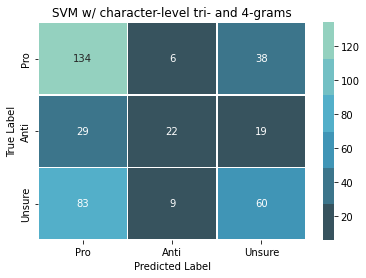

In [27]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ character-level tri- and 4-grams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [28]:
accuracy = metrics.accuracy_score(y_test,y_char34gram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_char34gram,pos_label=1,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.54
Precision: 0.5413242229095887
Recall: 0.54
F1 Score: 0.5227529303526255



## Character-Level 4- and 5-grams

In [29]:
x_data = vectorizer_char45gram.fit_transform(tweets)
x_data.shape

(1999, 61190)

In [30]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.2,random_state=42)

### Parameter-Tuning

In [31]:
char45gram_clf = svm.LinearSVC()
char45gram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
char45gram_grid = model_selection.GridSearchCV(char45gram_clf,param_grid=char45gram_parameters,scoring='f1_weighted',refit=True,cv=5)
char45gram_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [32]:
char45gram_grid_df = pd.DataFrame(char45gram_grid.cv_results_)
char45gram_grid.best_params_

{'C': 1}

### Evaluation

In [33]:
y_char45gram = char45gram_grid.predict(x_test)

In [34]:
sns_conf = metrics.confusion_matrix(y_test,y_char45gram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

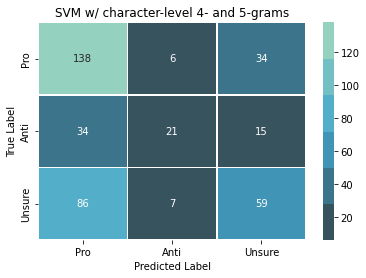

In [35]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ character-level 4- and 5-grams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [36]:
accuracy = metrics.accuracy_score(y_test,y_char45gram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_char45gram,pos_label=1,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.545
Precision: 0.5537040837006637
Recall: 0.545
F1 Score: 0.5248318630910374



# SVM with Discourse Features

In [37]:
discourse_features = DiscourseParsing()
x_data = discourse_features.vectorize(tweets)
x_data.shape

(1999, 16785)

In [38]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.2,random_state=42)

### Parameter Tuning

In [39]:
disc_clf = svm.LinearSVC()
disc_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
disc_grid = model_selection.GridSearchCV(disc_clf,param_grid=disc_parameters,scoring='f1_weighted',refit=True,cv=5)
disc_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [40]:
disc_grid_df = pd.DataFrame(disc_grid.cv_results_)
disc_grid.best_params_

{'C': 0.1}

### Evaluation

In [41]:
y_disc =disc_grid.predict(x_test)

In [42]:
sns_conf = metrics.confusion_matrix(y_test,y_disc,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

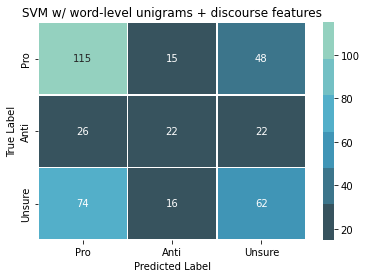

In [43]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ word-level unigrams + discourse features",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [44]:
accuracy = metrics.accuracy_score(y_test,y_disc)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_disc,pos_label=1,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.4975
Precision: 0.4891496137327643
Recall: 0.4975
F1 Score: 0.4889496889485613



# SVM with Emotion Features

In [45]:
lexipaths = {
    "VAD": "NRC-VAD-Lexicon/NRC-VAD-Lexicon.txt",
    "emotion": "NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    "affect intensity": "NRC-Affect-Intensity-Lexicon/NRC-AffectIntensity-Lexicon.txt"
}
big_folder = "NRC-Sentiment-Emotion-Lexicons"

In [60]:
anger = []
anger_int = []
disgust = []
joy_int = []
valence = []
emote = Emo(lexipaths,big_folder)
for t in tweets:
    if (emo := emote.classify_sentence(t,"emotion")):
        anger.append(emo[0]["anger"])
        disgust.append(emo[0]["disgust"])
    else:
        anger.append(0.0)
        disgust.append(0.0)
    if (emo_int := emote.classify_sentence(t,"affect intensity")):
        anger_int.append(emo_int[0]["anger"])
        joy_int.append(emo_int[0]["joy"])
    else:
        anger_int.append(0.0)
        joy_int.append(0.0)
    if (vad := emote.classify_sentence(t,"VAD")):
        valence.append(vad[0]["Valence"])
    else:
        valence.append(0.0)
    

In [61]:
x_data = vectorizer_unigram.fit_transform(tweets)
x_data = sparse.hstack([x_data,np.array(anger)[:,None],np.array(anger_int)[:,None],np.array(disgust)[:,None],np.array(joy_int)[:,None],np.array(valence)[:,None]])

In [62]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.2,random_state=42)

### Parameter Tuning

In [63]:
emo_clf = svm.LinearSVC()
emo_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
emo_grid = model_selection.GridSearchCV(emo_clf,param_grid=emo_parameters,scoring='f1_weighted',refit=True,cv=5)
emo_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [64]:
emo_grid_df = pd.DataFrame(emo_grid.cv_results_)
emo_grid.best_params_

{'C': 1000}

### Evaluation

In [65]:
y_emo = emo_grid.predict(x_test)

In [66]:
sns_conf = metrics.confusion_matrix(y_test,y_emo,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

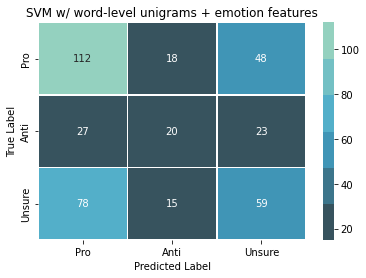

In [67]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ word-level unigrams + emotion features",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [68]:
accuracy = metrics.accuracy_score(y_test,y_emo)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_emo,pos_label=1,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.4775
Precision: 0.4681766936654338
Recall: 0.4775
F1 Score: 0.46827209168401945

